In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

In [2]:
data = pd.read_csv('breast-cancer.csv')
X = data.drop(['diagnosis'], axis=1)
y = data['diagnosis']
y = np.where(y == 'M', 1, -1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

# Реализация функций

In [3]:
# Вычисление отступа объекта
def margin(w, x, y):
    return y * np.dot(w, x)

In [4]:
def plot_margin(w, X, y):
    margins = sorted([margin(w, x_i, y_i) for x_i, y_i in zip(X, y)])
    plt.bar(range(len(margins)), margins, color=['red' if m < -0.25 else 'yellow' if m < 0.25 else 'green' for m in margins])
    plt.xlabel('Номер объекта')
    plt.ylabel('Отступ')
    plt.show()

In [5]:
# Рекуррентная оценка функционала качества
def recurrent_quality(Q, Xi, yi, tau):
    return Q * (1 - tau) + tau * (np.dot(w, Xi) - yi) ** 2

In [6]:
# Метод стохастического градиентного спуска с инерцией
def sgd_with_momentum(X, y, learning_rate=0.001, momentum=0.5, tau=0.1, num_epochs=1000, w=None):
    eps = 1e-7
    n_samples, n_features = X.shape
    if w is None:
        w = np.zeros(n_features)
    velocity = np.zeros(n_features)

    for epoch in range(num_epochs):
        i = random.randint(0, n_samples - 1)
        # вычисление градиента
        gradient = X[i] * (np.dot(w, X[i]) - y[i]) + w * tau
        velocity = momentum * velocity + learning_rate * gradient
        w -= velocity
            
        if np.linalg.norm(gradient) < eps:
            break
    
    return w

In [7]:
# Предъявление объектов по модулю отступа
def margin_sampling(w, X, y):
    margins = [margin(w, X[i], y[i]) for i in range(len(y))]
    indices = np.argsort(np.abs(margins))
    weights = [1 / (i + 1) for i in range(len(indices))]
    total_weight = sum(weights)
    probs = [w / total_weight for w in weights]
    return indices, probs

In [8]:
# Метод стохастического градиентного спуска с инерцией с предъявлением объектов по модулю отступа
def sgd_with_momentum_ms(X, y, learning_rate=0.001, momentum=0.5, tau=0.1, num_epochs=1000, w=None):
    eps = 1e-7
    n_samples, n_features = X.shape
    if w is None:
        w = np.zeros(n_features)
    velocity = np.zeros(n_features)

    indices, probs = margin_sampling(w, X, y)
    
    for epoch in range(num_epochs):
        i = random.choices(indices, weights=probs, k=1)[0]
        # вычисление градиента
        gradient = X[i] * (np.dot(w, X[i]) - y[i]) + w * tau
        velocity = momentum * velocity + learning_rate * gradient
        w -= velocity
            
        if np.linalg.norm(gradient) < eps:
            break
    
    return w

In [9]:
# Скорейший градиентный спуск
def fastest_gradient_descent(X, y, tau=0.1, num_epochs=100, w=None):
    eps = 1e-7
    n_samples, n_features = X.shape
    if w is None:
        w = np.zeros(n_features)

    for epoch in range(num_epochs):
        # вычисление градиента
        gradient = -2 * np.dot(X.T, (y - np.dot(X, w))) + 2 * tau * w
        
        numerator = np.dot(gradient.T, gradient)
        denominator = np.dot((np.dot(X, gradient)).T, np.dot(X, gradient))
        if denominator != 0:
            step = numerator / denominator
        else:
            step = 1.0
        
        w -= step * gradient
        if np.linalg.norm(gradient) < eps:
            break

    return w

In [10]:
# Инициализация весов через корреляцию
def correlation_init(X, y):
    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    for j in range(n_features):
        fj = X[:, j]
        numerator = np.dot(y, fj)
        denominator = np.dot(fj, fj)
        if denominator != 0:
            w[j] = numerator / denominator
        else:
            w[j] = 0
    return w

In [11]:
# Случайная инициализация весов через мультистарт
def multi_start_initialization(X, y, tau=0.1, n_restarts=50, method='M'):
    n_samples, n_features = X.shape
    best_w = None
    best_loss = float('inf')

    for _ in range(n_restarts):
        w = np.random.randn(n_features)
        if method == 'M':
            w = sgd_with_momentum(X, y, learning_rate=0.001, momentum=0.5, tau=tau, num_epochs=10000, w=w)
        else:
            w = fastest_gradient_descent(X, y, tau=tau, num_epochs=100, w=w)
        loss = np.mean((np.dot(X, w) - y) ** 2) + tau * np.sum(w ** 2)
        if loss < best_loss:
            best_loss = loss
            best_w = w

    return best_w, best_loss

# Тестирование результатов

In [12]:
def results(w, X, y):
  print(classification_report(y, np.sign(np.dot(X, w))))

              precision    recall  f1-score   support

          -1       0.99      0.93      0.96        90
           1       0.90      0.98      0.94        53

    accuracy                           0.95       143
   macro avg       0.94      0.96      0.95       143
weighted avg       0.95      0.95      0.95       143



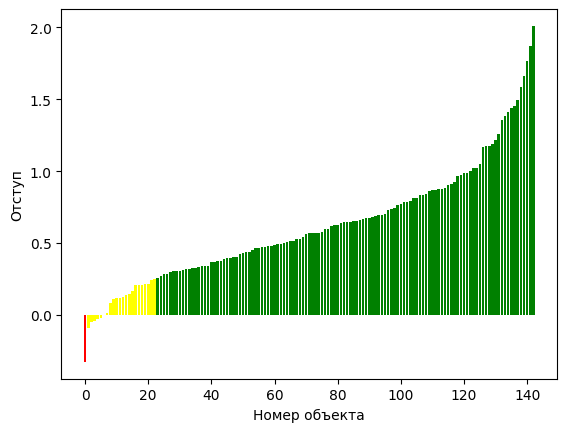

In [13]:
w = sgd_with_momentum(X_train.values, y_train)
results(w, X_test.values, y_test)
plot_margin(w, X_test.values, y_test)

              precision    recall  f1-score   support

          -1       0.99      0.97      0.98        90
           1       0.95      0.98      0.96        53

    accuracy                           0.97       143
   macro avg       0.97      0.97      0.97       143
weighted avg       0.97      0.97      0.97       143



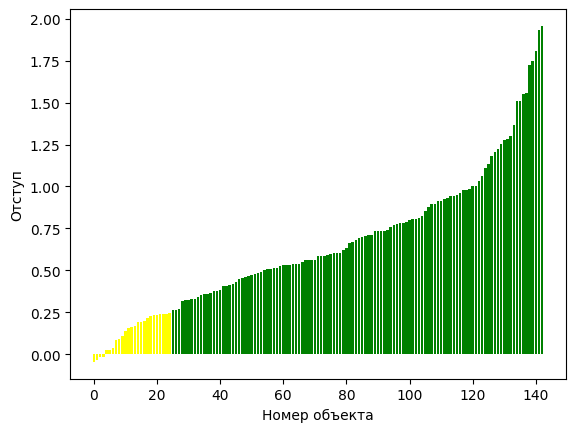

In [14]:
w = correlation_init(X_train.values, y_train)
w = sgd_with_momentum(X_train.values, y_train, w=w)
results(w, X_test.values, y_test)
plot_margin(w, X_test.values, y_test)

              precision    recall  f1-score   support

          -1       0.99      0.97      0.98        90
           1       0.95      0.98      0.96        53

    accuracy                           0.97       143
   macro avg       0.97      0.97      0.97       143
weighted avg       0.97      0.97      0.97       143



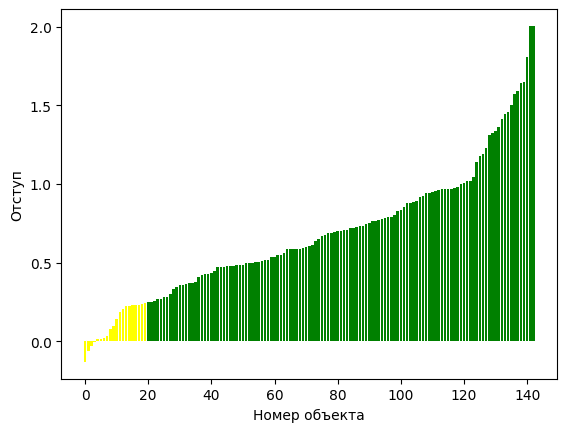

In [15]:
w, loss = multi_start_initialization(X_train.values, y_train, method='M')
results(w, X_test.values, y_test)
plot_margin(w, X_test.values, y_test)

              precision    recall  f1-score   support

          -1       0.97      0.93      0.95        90
           1       0.89      0.94      0.92        53

    accuracy                           0.94       143
   macro avg       0.93      0.94      0.93       143
weighted avg       0.94      0.94      0.94       143



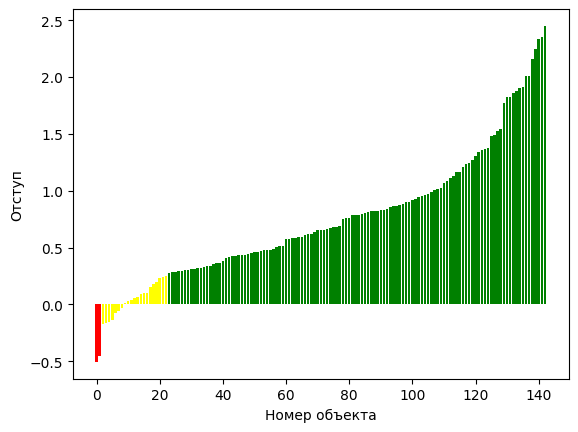

In [16]:
w = correlation_init(X_train.values, y_train)
w = sgd_with_momentum_ms(X_train.values, y_train, w=w)
results(w, X_test.values, y_test)
plot_margin(w, X_test.values, y_test)

              precision    recall  f1-score   support

          -1       0.69      0.52      0.59        90
           1       0.43      0.60      0.50        53

    accuracy                           0.55       143
   macro avg       0.56      0.56      0.55       143
weighted avg       0.59      0.55      0.56       143



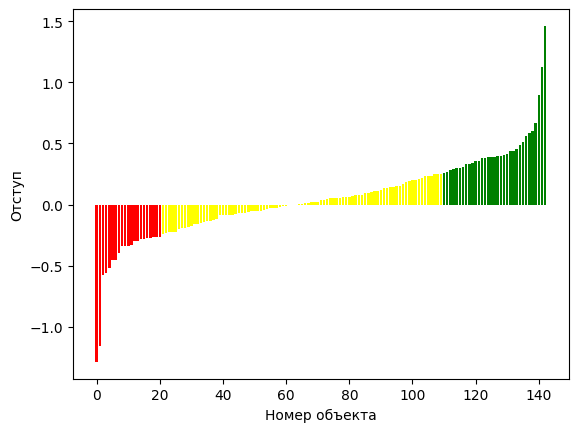

In [17]:
w = fastest_gradient_descent(X_train.values, y_train)
results(w, X_test.values, y_test)
plot_margin(w, X_test.values, y_test)

              precision    recall  f1-score   support

          -1       0.95      0.92      0.94        90
           1       0.88      0.92      0.90        53

    accuracy                           0.92       143
   macro avg       0.91      0.92      0.92       143
weighted avg       0.92      0.92      0.92       143



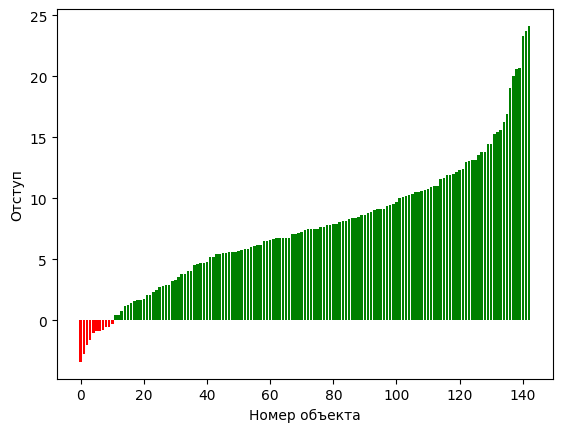

In [18]:
w = correlation_init(X_train.values, y_train)
w = fastest_gradient_descent(X_train.values, y_train, w=w)
results(w, X_test.values, y_test)
plot_margin(w, X_test.values, y_test)

              precision    recall  f1-score   support

          -1       0.97      0.94      0.96        90
           1       0.91      0.94      0.93        53

    accuracy                           0.94       143
   macro avg       0.94      0.94      0.94       143
weighted avg       0.94      0.94      0.94       143



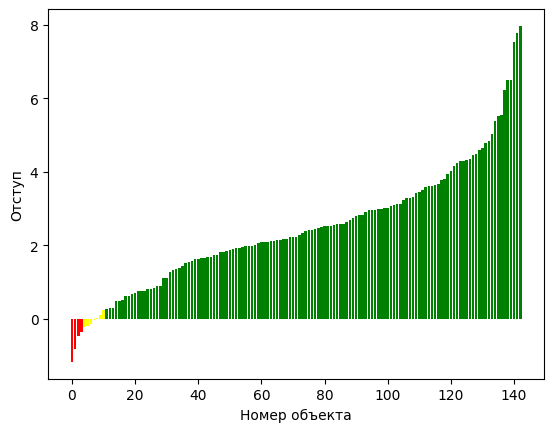

In [19]:
w, loss = multi_start_initialization(X_train.values, y_train, n_restarts=1000, method='F')
results(w, X_test.values, y_test)
plot_margin(w, X_test.values, y_test)

In [20]:
sgdc = SGDClassifier(loss='squared_error', alpha=0.1, penalty='l2', learning_rate='constant', eta0=0.01, max_iter=1000, random_state=42)
sgdc.fit(X_train, y_train)
y_pred = sgdc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.95      0.99      0.97        90
           1       0.98      0.91      0.94        53

    accuracy                           0.96       143
   macro avg       0.96      0.95      0.95       143
weighted avg       0.96      0.96      0.96       143

